## Motivation

Job scams have become an increasingly prevalent issue in Singapore, with fraudsters exploiting job seekers through deceptive advertisements on social media and job platforms. These scams not only cause financial losses but also inflict psychological distress on victims who may lose trust in legitimate employment opportunities.

As part of this technical assessment, I aim to explore the data, perform the necessary preprocessing techniques and develop a robust and adaptive algorithm to detect and prevent fraudulent job postings before they reach unsuspecting users. Given the rapid evolution of scam tactics, traditional rule-based methods may no longer be sufficient. A data-driven, machine learning approach enables us to dynamically identify and flag suspicious job listings based on linguistic patterns, metadata and other key indicators.

## Recruitment Scam Dataset Information

The [Recruitment Scam Dataset](https://www.kaggle.com/datasets/amruthjithrajvr/recruitment-scam) is a publicly available dataset containing 17880 real-life job ads, the  dataset contains 17014 legitimate and 866 fraudulent job ads published between 2012 to 2014.

The dimensions are shown below:
- **title:**: Title of job ad.
- **location:** Location of job.
- **department:** Department of company which the job belong.
- **salary_range:** Salary range of job.
- **salary_range:** Salary range of job.
- **company_profile:** Company profile.
- **description:** Description of job.
- **requirements:** Job requirements.
- **benefits:** Job benefits.
- **telecommuting:** `t` (True) or `f` (False).
- **has_company_logo:** `t` (True) or `f` (False).
- **has_questions:** `t` (True) or `f` (False).
- **employment_type:** Type of employment.
- **required_experience:** Experience required.
- **required_education:** Education required.
- **industry:** Type of industry.
- **function:** Job function.
- **fraudulent:** Target Variable: `t` (fraudulent), `f` (not fraudulent).
- **in_balanced_dataset:** `t` (True), `f` (False).

The Recruitment Scam Dataset is stored in `data.csv`.

## Import Libraries

Please uncomment the code box below to pip install relevant dependencies for this notebook.

In [17]:
# !pip3 install -r requirements.txt

In [54]:
# Import necessary libraries

# Data manipulation
import pandas as pd
import numpy as np

# Statistical functions
from scipy.stats import zscore

# For concurrency (running functions in parallel)
from concurrent.futures import ThreadPoolExecutor

# For caching (to speed up repeated function calls)
from functools import lru_cache

# For progress tracking
from tqdm import tqdm

# Plotting and Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Text Preprocessing and NLP
# Stopwords (common words to ignore) from NLTK
from nltk.corpus import stopwords
# Tokenizing sentences/words
from nltk.tokenize import word_tokenize
# Part-of-speech tagging
from nltk import pos_tag
# Lemmatization (converting words to their base form)
from nltk.stem import WordNetLemmatizer
import nltk
# Regular expressions for text pattern matching
import re

# Word Cloud generation
from wordcloud import WordCloud

# Data Preparation (Loading CSV)

Load the dataset `data.csv` file into a pandas DataFrame
- `data.csv` is loaded into `df` DataFrame.

In [55]:
df = pd.read_csv('data.csv')

In [56]:
df.info()
print("Dataframe Shape:", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17880 non-null  object
 6   requirements         15191 non-null  object
 7   benefits             10684 non-null  object
 8   telecommuting        17880 non-null  object
 9   has_company_logo     17880 non-null  object
 10  has_questions        17880 non-null  object
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  frau

In [57]:
df.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"<h3>We're Food52, and we've created a groundbr...","<p>Food52, a fast-growing, James Beard Award-w...",<ul>\r\n<li>Experience with content management...,NaN,f,t,f,Other,Internship,NaN,NaN,Marketing,f,f
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"<h3>90 Seconds, the worlds Cloud Video Product...",<p>Organised - Focused - Vibrant - Awesome!<br...,<p><b>What we expect from you:</b></p>\r\n<p>Y...,<h3><b>What you will get from us</b></h3>\r\n<...,f,t,f,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,f,f
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,<h3></h3>\r\n<p>Valor Services provides Workfo...,"<p>Our client, located in Houston, is actively...",<ul>\r\n<li>Implement pre-commissioning and co...,NaN,f,t,f,NaN,NaN,NaN,NaN,NaN,f,f
3,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,<p>Our passion for improving quality of life t...,<p><b>THE COMPANY: ESRI – Environmental System...,<ul>\r\n<li>\r\n<b>EDUCATION: </b>Bachelor’s o...,<p>Our culture is anything but corporate—we ha...,f,t,f,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,f,f
4,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,<p>SpotSource Solutions LLC is a Global Human ...,<p><b>JOB TITLE:</b> Itemization Review Manage...,<p><b>QUALIFICATIONS:</b></p>\r\n<ul>\r\n<li>R...,<p>Full Benefits Offered</p>,f,t,t,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,f,f


In [58]:
# Check the fraud distribution
fraud_counts = df["fraudulent"].value_counts()
fraud_counts

fraudulent
f    17014
t      866
Name: count, dtype: int64

Here we check the distribution of the `fraudulent` column (target variable).

We can see that the dataset is highly imbalanced, with only less than 5% of the listings are fraudulent (`"t"`) and this may lead to poor model performance (favouring the majority class).

In [59]:
# Convert fraudulent column to binary (0 = non-fraud, 1 = fraud)
df["fraudulent"] = df["fraudulent"].map({"f": 0, "t": 1})

C:\Users\Redbu\AppData\Local\Temp\ipykernel_3656\3876087425.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette=["blue", "red"])


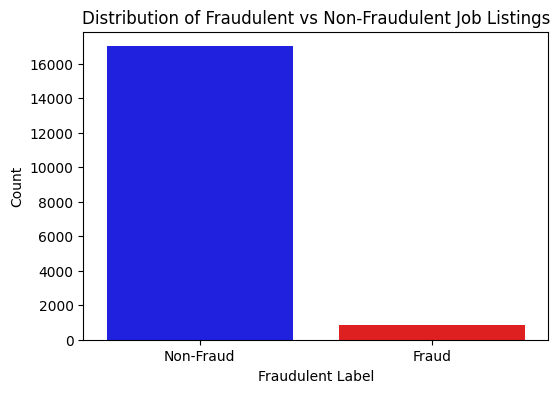

In [60]:
# Plot Fraud vs Non-Fraud Distribution
plt.figure(figsize=(6,4))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette=["blue", "red"])
plt.xticks(ticks=[0, 1], labels=["Non-Fraud", "Fraud"])
plt.ylabel("Count")
plt.xlabel("Fraudulent Label")
plt.title("Distribution of Fraudulent vs Non-Fraudulent Job Listings")
plt.show()

Below we will check the distribution of fraudulent vs non-fraudulent job listings for the top 10 `location`.

C:\Users\Redbu\AppData\Local\Temp\ipykernel_3656\4147777464.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_non_fraud.values, y=top_non_fraud.index, palette="Blues_r", ax=axes[0])
C:\Users\Redbu\AppData\Local\Temp\ipykernel_3656\4147777464.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_fraud.values, y=top_fraud.index, palette="Reds_r", ax=axes[1])


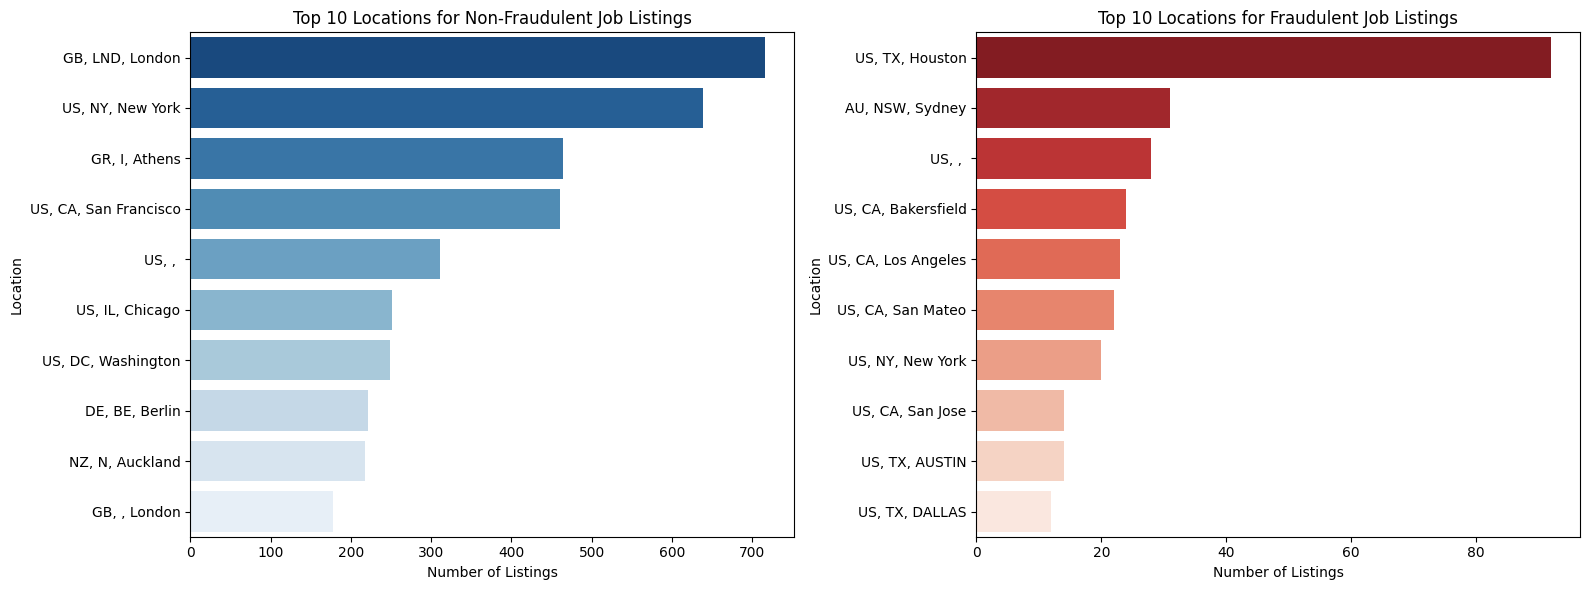

In [61]:
top_non_fraud = df[df["fraudulent"] == 0]["location"].value_counts().nlargest(10)
top_fraud = df[df["fraudulent"] == 1]["location"].value_counts().nlargest(10)

# Set up the figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot non-fraudulent job locations
sns.barplot(x=top_non_fraud.values, y=top_non_fraud.index, palette="Blues_r", ax=axes[0])
axes[0].set_title("Top 10 Locations for Non-Fraudulent Job Listings")
axes[0].set_xlabel("Number of Listings")
axes[0].set_ylabel("Location")

# Plot fraudulent job locations
sns.barplot(x=top_fraud.values, y=top_fraud.index, palette="Reds_r", ax=axes[1])
axes[1].set_title("Top 10 Locations for Fraudulent Job Listings")
axes[1].set_xlabel("Number of Listings")
axes[1].set_ylabel("Location")

# Show the plots
plt.tight_layout()
plt.show()

Here we will dive deeper into location-based fraud trends and see the fraud percentage in the top 20 job locations.

From the bar chart below, we can see that some locations such as Houston and Los Angeles have higher fraud rates, meaning a larger proportion of job postings from those areas are scams.

It is also possible that these locations may act as hubs for fraudulent job postings, possibly due to lax job verification policies.

C:\Users\Redbu\AppData\Local\Temp\ipykernel_3656\539385512.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_location["Fraud Percentage"], y=fraud_by_location.index, palette="coolwarm")


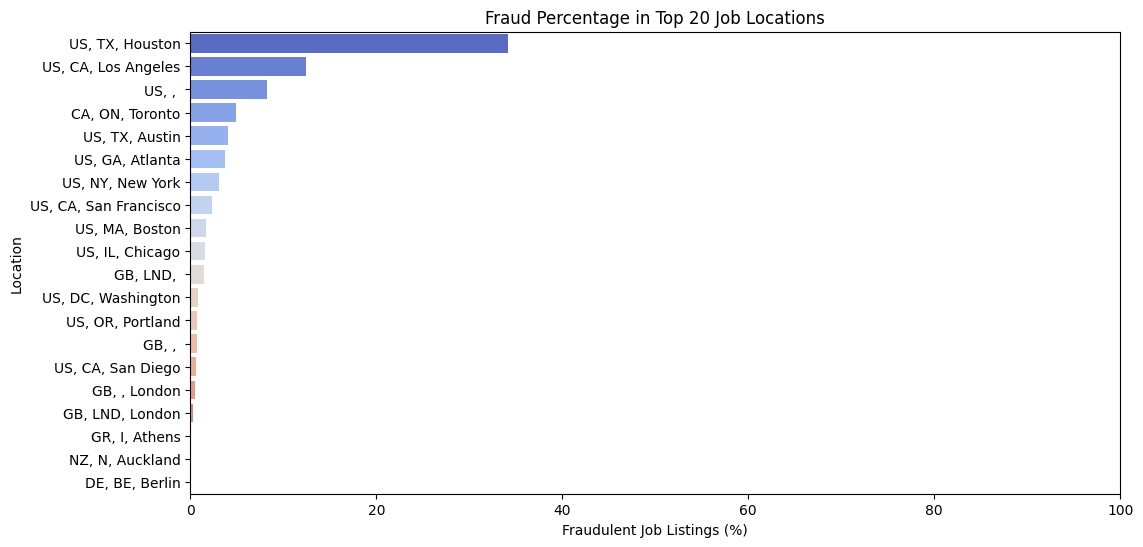

In [62]:
# Analyze the proportion of fraudulent vs. non-fraudulent jobs in the most common locations
top_locations = df["location"].value_counts().nlargest(20).index  # Select top 20 locations
df_top_locations = df[df["location"].isin(top_locations)]

# Pivot the data to get fraud proportions per location
fraud_by_location = df_top_locations.pivot_table(index="location", columns="fraudulent", aggfunc="size", fill_value=0)
fraud_by_location.columns = ["Non-Fraudulent", "Fraudulent"]

# Calculate fraud percentage per location
fraud_by_location["Fraud Percentage"] = (fraud_by_location["Fraudulent"] / 
                                         (fraud_by_location["Fraudulent"] + fraud_by_location["Non-Fraudulent"])) * 100

# Sort by fraud percentage
fraud_by_location = fraud_by_location.sort_values(by="Fraud Percentage", ascending=False)

# Plot fraud percentage across top locations
plt.figure(figsize=(12, 6))
sns.barplot(x=fraud_by_location["Fraud Percentage"], y=fraud_by_location.index, palette="coolwarm")
plt.xlabel("Fraudulent Job Listings (%)")
plt.ylabel("Location")
plt.title("Fraud Percentage in Top 20 Job Locations")
plt.xlim(0, 100)

# Show the plot
plt.show()

Here we look at industry-based fraud analysis where we see which `industry` have the most fraudulent job postings.

C:\Users\Redbu\AppData\Local\Temp\ipykernel_3656\3994811957.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_fraud_industries.index, x=top_fraud_industries.values, palette="Reds_r", ax=axes[0])
C:\Users\Redbu\AppData\Local\Temp\ipykernel_3656\3994811957.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_non_fraud_industries.index, x=top_non_fraud_industries.values, palette="Blues_r", ax=axes[1])


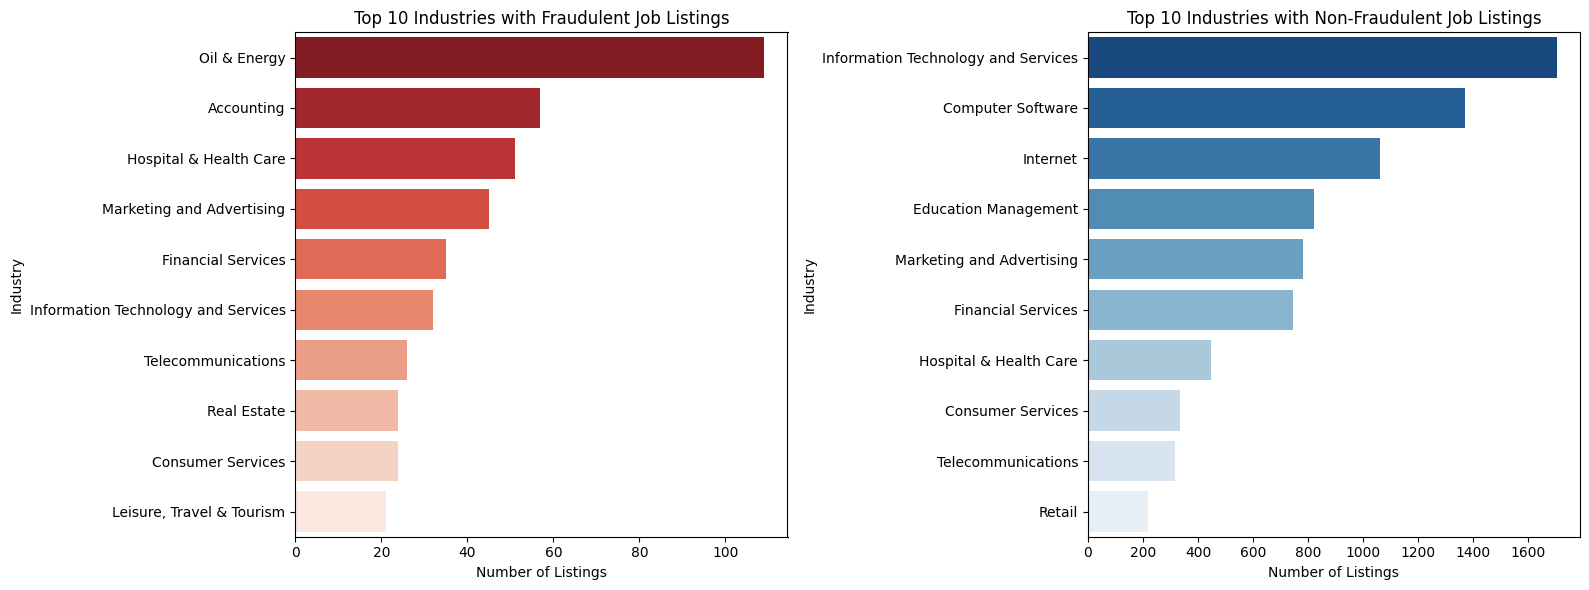

In [63]:
# Get top industries for overall job listings
top_industries = df["industry"].value_counts().nlargest(10)

# Get top industries for fraudulent and non-fraudulent listings separately
top_fraud_industries = df[df["fraudulent"] == 1]["industry"].value_counts().nlargest(10)
top_non_fraud_industries = df[df["fraudulent"] == 0]["industry"].value_counts().nlargest(10)

# Set up figure for two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot top industries for fraudulent job listings
sns.barplot(y=top_fraud_industries.index, x=top_fraud_industries.values, palette="Reds_r", ax=axes[0])
axes[0].set_title("Top 10 Industries with Fraudulent Job Listings")
axes[0].set_xlabel("Number of Listings")
axes[0].set_ylabel("Industry")

# Plot top industries for non-fraudulent job listings
sns.barplot(y=top_non_fraud_industries.index, x=top_non_fraud_industries.values, palette="Blues_r", ax=axes[1])
axes[1].set_title("Top 10 Industries with Non-Fraudulent Job Listings")
axes[1].set_xlabel("Number of Listings")
axes[1].set_ylabel("Industry")

# Show the plots
plt.tight_layout()
plt.show()

However, some industries naturally have more job listings overall, which can skew the numbers. Therefore instead of just showing total counts, we can improve on the above plot by calculate the % of fraudulent jobs per industry to identify high-risk industries.

C:\Users\Redbu\AppData\Local\Temp\ipykernel_3656\1365318065.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_10_fraud_proportion.index, x=top_10_fraud_proportion.values, palette="Reds_r")


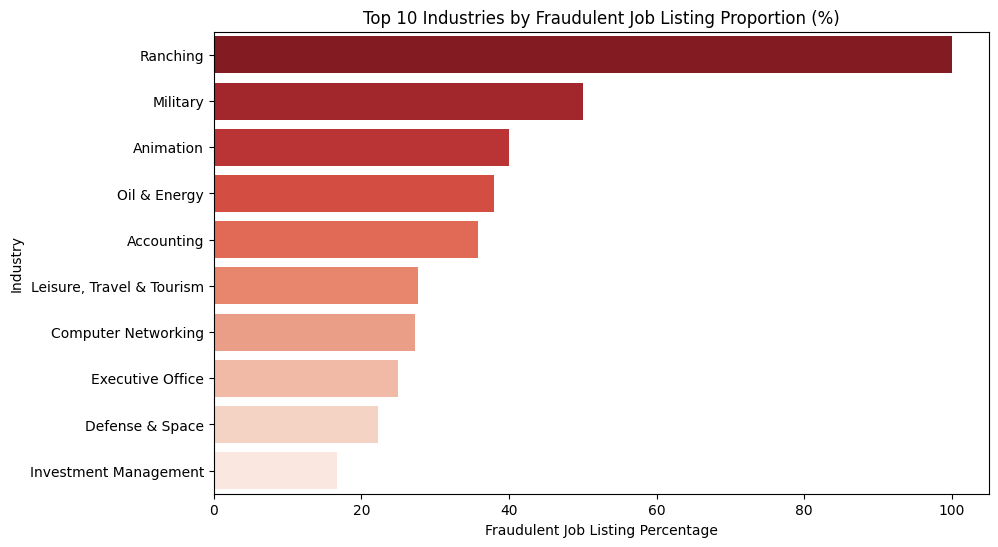

In [64]:
# Calculate the total number of job listings per industry
total_jobs_per_industry = df['industry'].value_counts()

# Calculate the total number of fraudulent job listings per industry
fraud_jobs_per_industry = df[df['fraudulent'] == 1]['industry'].value_counts()

# Calculate the proportion of fraudulent job listings per industry
fraud_proportion = (fraud_jobs_per_industry / total_jobs_per_industry).fillna(0) * 100

# Get the top 10 industries with the highest fraud proportion
top_10_fraud_proportion = fraud_proportion.sort_values(ascending=False).head(10)

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(y=top_10_fraud_proportion.index, x=top_10_fraud_proportion.values, palette="Reds_r")
plt.title("Top 10 Industries by Fraudulent Job Listing Proportion (%)")
plt.xlabel("Fraudulent Job Listing Percentage")
plt.ylabel("Industry")
plt.show()


From the above plot we can see that certain industries that do not have the highest number of fraudulent jobs but sitll have a high proportion of scams, such as "Ranching" and "Military". This might indicate that if a industry has a small number of total jobs listings but a high fraud rate, scammer might disproportionately target that industry.

Below we look at the distribution of fraud vs. non-fraud job listings for `employment_type`.

C:\Users\Redbu\AppData\Local\Temp\ipykernel_3656\1600935279.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=fraud_value_counts.index, x=fraud_value_counts.values, palette="Reds_r", ax=axes[0])
C:\Users\Redbu\AppData\Local\Temp\ipykernel_3656\1600935279.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=non_fraud_value_counts.index, x=non_fraud_value_counts.values, palette="Blues_r", ax=axes[1])


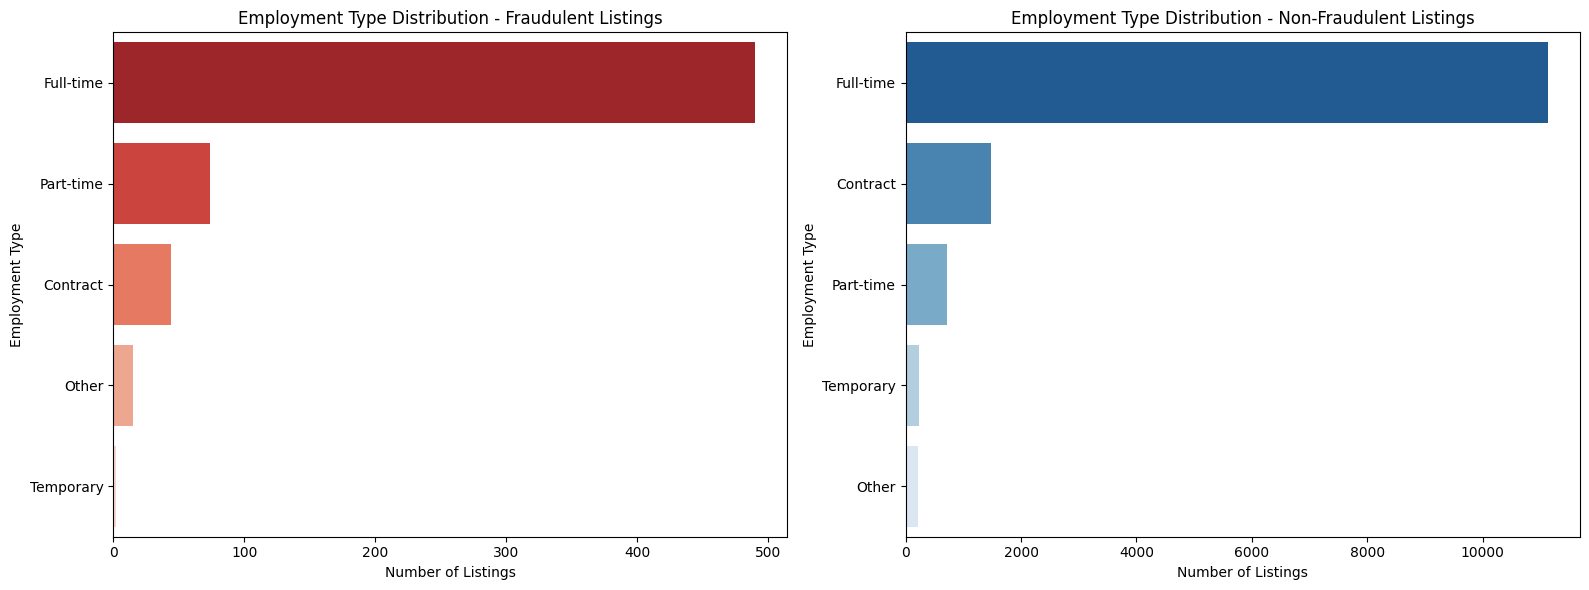

In [65]:
# Get employment type in fraudulent and non-fraudulent listings
fraud_employment = df[df["fraudulent"] == 1]["employment_type"]
non_fraud_employment = df[df["fraudulent"] == 0]["employment_type"]

fraud_value_counts = fraud_employment.apply(lambda x: str(x) if not pd.isna(x) else np.nan).value_counts()
non_fraud_value_counts = non_fraud_employment.apply(lambda x: str(x) if not pd.isna(x) else np.nan).value_counts()

# Set up figure for two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot fraudulent job employment types
sns.barplot(y=fraud_value_counts.index, x=fraud_value_counts.values, palette="Reds_r", ax=axes[0])
axes[0].set_title("Employment Type Distribution - Fraudulent Listings")
axes[0].set_xlabel("Number of Listings")
axes[0].set_ylabel("Employment Type")

# Plot non-fraudulent job employment types
sns.barplot(y=non_fraud_value_counts.index, x=non_fraud_value_counts.values, palette="Blues_r", ax=axes[1])
axes[1].set_title("Employment Type Distribution - Non-Fraudulent Listings")
axes[1].set_xlabel("Number of Listings")
axes[1].set_ylabel("Employment Type")

# Show the plots
plt.tight_layout()
plt.show()


Similar to `industry`, we show the proportion of fraudulent vs. non-fraudulent job listings for each `employment_type`.

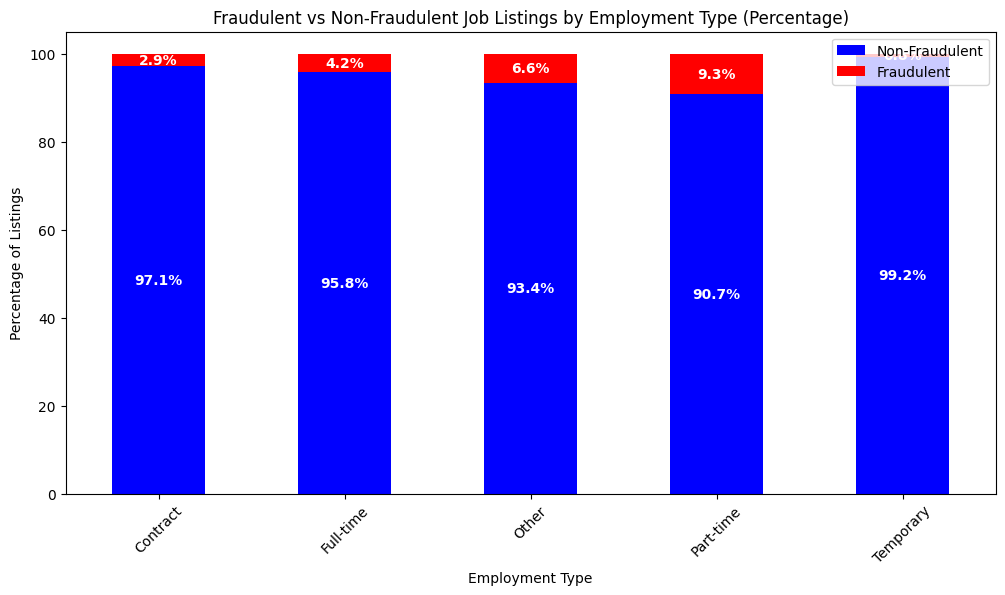

In [ ]:
# Count fraudulent and non-fraudulent jobs for each employment type
employment_counts = df.groupby(["employment_type", "fraudulent"]).size().unstack()

# Normalize to get percentages for each employment type
employment_counts_pct = employment_counts.div(employment_counts.sum(axis=1), axis=0) * 100

# Plot stacked bar chart with percentages
fig, ax = plt.subplots(figsize=(12, 6))
bars = employment_counts_pct.plot(kind="bar", stacked=True, ax=ax, color=["blue", "red"])

# Add percentage labels on bars
for i, bars in enumerate(ax.containers):
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Only label non-zero values
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X position
                bar.get_y() + height / 2,  # Y position
                f"{height:.1f}%",  # Label text
                ha="center", va="center", fontsize=10, color="white", fontweight="bold"
            )

# Labels and title
plt.xlabel("Employment Type")
plt.ylabel("Percentage of Listings")
plt.title("Fraudulent vs Non-Fraudulent Job Listings by Employment Type (Percentage)")
plt.legend(["Non-Fraudulent", "Fraudulent"], loc="upper right")
plt.xticks(rotation=45)

# Show the plot
plt.show()

As we can see, part-time jobs have the largest proportion of fraudulent job listings at aroud 9%

Next, we analyse the distribution and percentages of fraudulent vs. non-fraudulent job listings for `required_experience` feature.

C:\Users\Redbu\AppData\Local\Temp\ipykernel_3656\704576106.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=fraud_value_counts.index, x=fraud_value_counts.values, palette="Reds_r", ax=axes[0])
C:\Users\Redbu\AppData\Local\Temp\ipykernel_3656\704576106.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=non_fraud_value_counts.index, x=non_fraud_value_counts.values, palette="Blues_r", ax=axes[1])


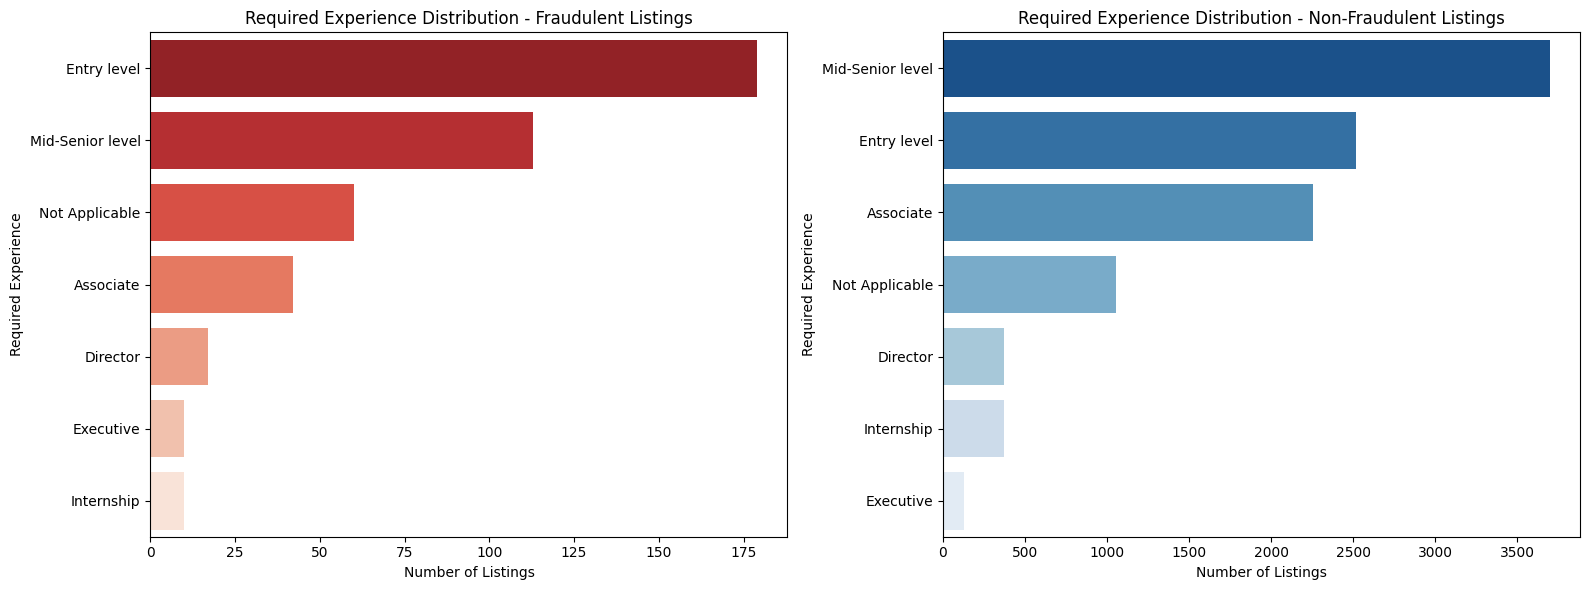

In [75]:
# Get required_experience in fraudulent and non-fraudulent listings
fraud_experience = df[df["fraudulent"] == 1]["required_experience"]
non_fraud_experience = df[df["fraudulent"] == 0]["required_experience"]

fraud_value_counts = fraud_experience.apply(lambda x: str(x) if not pd.isna(x) else np.nan).value_counts()
non_fraud_value_counts = non_fraud_experience.apply(lambda x: str(x) if not pd.isna(x) else np.nan).value_counts()

# Set up figure for two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot fraudulent job experience requirements
sns.barplot(y=fraud_value_counts.index, x=fraud_value_counts.values, palette="Reds_r", ax=axes[0])
axes[0].set_title("Required Experience Distribution - Fraudulent Listings")
axes[0].set_xlabel("Number of Listings")
axes[0].set_ylabel("Required Experience")

# Plot non-fraudulent job experience requirements
sns.barplot(y=non_fraud_value_counts.index, x=non_fraud_value_counts.values, palette="Blues_r", ax=axes[1])
axes[1].set_title("Required Experience Distribution - Non-Fraudulent Listings")
axes[1].set_xlabel("Number of Listings")
axes[1].set_ylabel("Required Experience")

# Show the plots
plt.tight_layout()
plt.show()

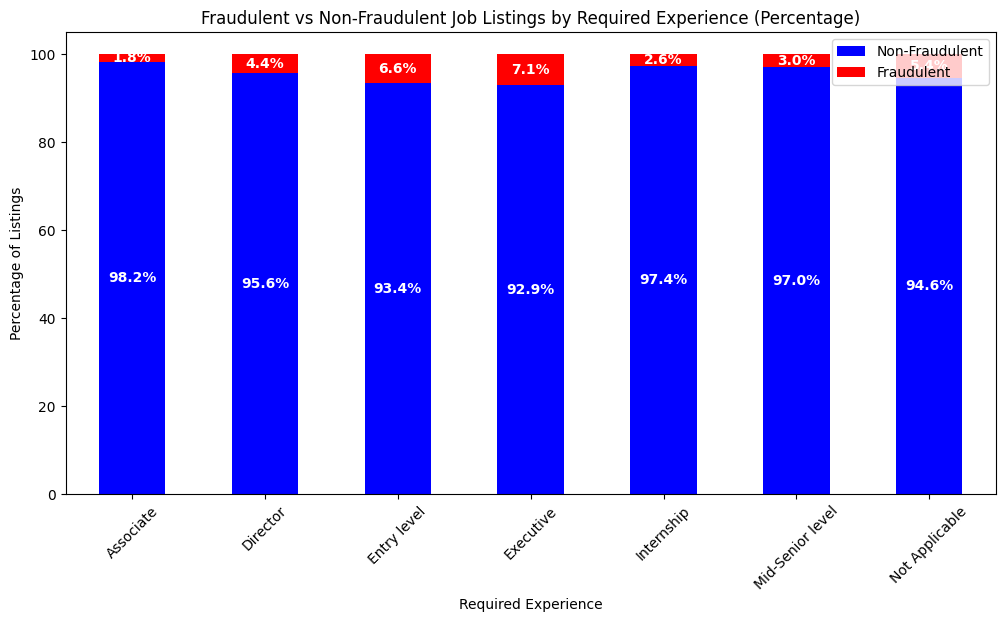

In [ ]:
# Count fraudulent and non-fraudulent jobs for each experience level
experience_counts = df.groupby(["required_experience", "fraudulent"]).size().unstack()

# Normalize to get percentages for each required experience level
experience_counts_pct = experience_counts.div(experience_counts.sum(axis=1), axis=0) * 100

# Plot stacked bar chart with percentages
fig, ax = plt.subplots(figsize=(12, 6))
bars = experience_counts_pct.plot(kind="bar", stacked=True, ax=ax, color=["blue", "red"])

# Add percentage labels on bars
for i, bars in enumerate(ax.containers):
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Only label non-zero values
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X position
                bar.get_y() + height / 2,  # Y position
                f"{height:.1f}%",  # Label text
                ha="center", va="center", fontsize=10, color="white", fontweight="bold"
            )

# Labels and title
plt.xlabel("Required Experience")
plt.ylabel("Percentage of Listings")
plt.title("Fraudulent vs Non-Fraudulent Job Listings by Required Experience (Percentage)")
plt.legend(["Non-Fraudulent", "Fraudulent"], loc="upper right")
plt.xticks(rotation=45)

# Show the plot
plt.show()

As we can see, the distribution of fraudulent job listings are quite spread out across all the required experience, with executive having the highest percentage at 7.1%.

In [45]:
# Check unique values in 'in_balanced_dataset' column
df["in_balanced_dataset"].value_counts()

in_balanced_dataset
f    16980
t      900
Name: count, dtype: int64

In [46]:
# Convert 'in_balanced_dataset' column to binary (0 = full dataset, 1 = balanced dataset)
df["in_balanced_dataset"] = df["in_balanced_dataset"].map({"f": 0, "t": 1})

This suggests that 900 entries were selected to form a balanced dataset, possibly for model training purposes.

In [47]:
# Check the distribution of fraudulent vs. non-fraudulent listings in the balanced dataset
df[df["in_balanced_dataset"] == 1]["fraudulent"].value_counts()

fraudulent
1    450
0    450
Name: count, dtype: int64

We can see that the balanced dataset has an equal distribution of fraudulent vs. non-fraudulent job listings, which is better for model training purposes since the model will learn from equal representations of both classes.

Here we check the percentage of missing values for each dimension.

In [48]:
# Check missing values in the dataset
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values_percentage = (df.isnull().sum() / len(df)) * 100

# Combine results into a DataFrame
missing_data = pd.DataFrame({"Missing Count": missing_values, "Missing %": missing_values_percentage})
missing_data = missing_data[missing_data["Missing Count"] > 0]  # Filter out dimensions without missing values

missing_data

,Missing Count,Missing %
benefits,7196,40.246085
company_profile,3308,18.501119
department,11547,64.580537
employment_type,3471,19.412752
function,6455,36.101790
industry,4903,27.421700
location,346,1.935123
required_education,8105,45.329978
required_experience,7050,39.429530
requirements,2689,15.039150


C:\Users\Redbu\AppData\Local\Temp\ipykernel_3656\3241593408.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


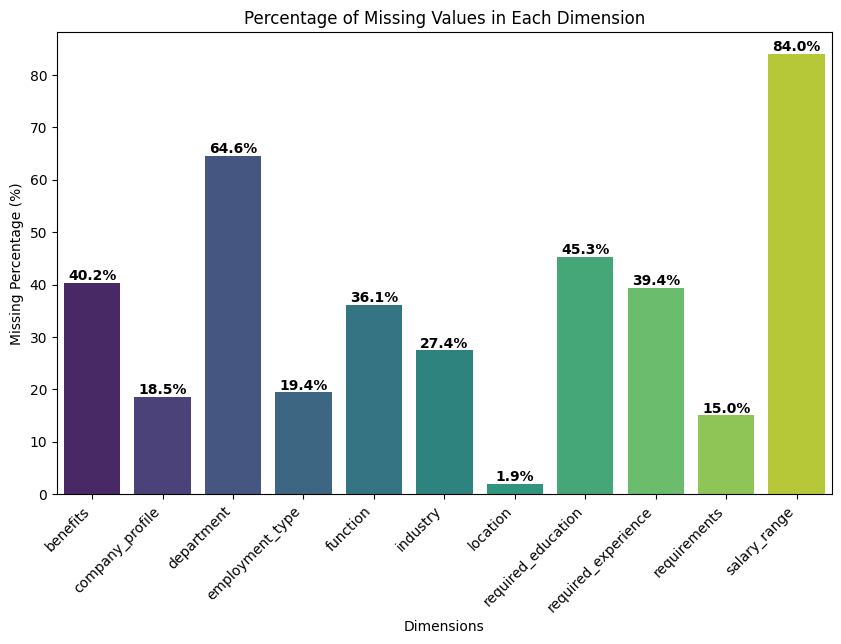

In [49]:
# Display missing data as a bar chart

# Set up figure size
plt.figure(figsize=(10, 6))

# Plot missing values as a bar chart
ax = sns.barplot(
    x=missing_data.index, 
    y=missing_data["Missing %"], 
    palette="viridis"
)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Labels and title
plt.ylabel("Missing Percentage (%)")
plt.xlabel("Dimensions")
plt.title("Percentage of Missing Values in Each Dimension")

# Annotate each bar with the missing percentage value
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

# Show plot
plt.show()

We can see that some features (like `department`, `required_education`, and `salary_range`) have significant missing values. This helps determine whether to impute, drop, or ignore these features based on their importance which we will explore later.

## Handling Missing Values

We will drop columns that have too many missing values and less useful
- `department`: We drop this column because the department of a job listing is unlikely to provide strong signals for fraud detection and % of missing values is 64% which is very high.
- `salary_range`: We drop this column as it has 84% missing values, and salary is often missing even in real job listings in the real world.

We will impute certain columns when those columns have a moderate amount of missing values and are important.
- `benefits`: Replace `NaN` with `"No Benefits Provided"` ensures we differentiate between jobs that explicitly mention benefits vs. those that don't.
- `company_profile`: Fill `NaN` with `"Unknown"` since a missing company profile can be a strong fraud indicator (legitimate companies usually describe themselves), a missing profile is valuable information rather than just missing data.
- `employment_type`: Replace `NaN` with `"Unknown"` since some real job postings intentionally do not specify employment type, and also ensures that the column retains categorical structure instead of introducing NaN issues.
- `required_experience`: Replace `NaN` with `"Not Specified"` ensures we retain all job postings for analysis.
- `required_education`: Replace `NaN` with `"Not Specified"` prevents dropping data while keeping this fraud indicator intact since missing education details might correlate with fraudulence.
- `industry`: Replace `NaN` with `"Unknown"`, can use for industry classification for detecting scam patterns in specific job sectors.
- `function`: Replace `NaN` with `"Unknown"`, similar to `industry`.

Lastly, we will ignore certain columns when missing values are low and do not require imputation.
- `location`: only a small number of missing values, model can handle it, also locations are often inconsistently formatted (e.g. "US, NY, New York" vs. "Singapore") making imputation tricky
- `requirements`: low number of missing values, also imputing might remove the natural variability since some legitimate job posts naturally do not list requirements, and fraudulent listings may also omit requirements to attract more applicants.

In [50]:
# Drop columns with too many missing values
df.drop(columns=["department", "salary_range"], inplace=True)

# Impute missing values with appropriate replacements
df["benefits"].fillna("No Benefits Provided", inplace=True)
df["company_profile"].fillna("No Company Profile Available", inplace=True)
df["employment_type"].fillna("Unknown", inplace=True)
df["required_experience"].fillna("Not Specified", inplace=True)
df["required_education"].fillna("Not Specified", inplace=True)
df["industry"].fillna("Unknown", inplace=True)
df["function"].fillna("Unknown", inplace=True)

# The 'location' and 'requirements' columns are ignored for now

# Verify that missing values are handled
missing_values_after = df.isnull().sum()

# Display updated missing values summary
missing_values_after[missing_values_after > 0]

C:\Users\Redbu\AppData\Local\Temp\ipykernel_3656\1443836787.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["benefits"].fillna("No Benefits Provided", inplace=True)
C:\Users\Redbu\AppData\Local\Temp\ipykernel_3656\1443836787.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

location         346
requirements    2689
dtype: int64

In [51]:
# Check the dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   company_profile      17880 non-null  object
 3   description          17880 non-null  object
 4   requirements         15191 non-null  object
 5   benefits             17880 non-null  object
 6   telecommuting        17880 non-null  object
 7   has_company_logo     17880 non-null  object
 8   has_questions        17880 non-null  object
 9   employment_type      17880 non-null  object
 10  required_experience  17880 non-null  object
 11  required_education   17880 non-null  object
 12  industry             17880 non-null  object
 13  function             17880 non-null  object
 14  fraudulent           17880 non-null  int64 
 15  in_balanced_dataset  17880 non-null  int64 
dtypes: i

In [52]:
df.head()

,title,location,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
0,Marketing Intern,"US, NY, New York","<h3>We're Food52, and we've created a groundbr...","<p>Food52, a fast-growing, James Beard Award-w...",<ul>\r\n<li>Experience with content management...,No Benefits Provided,f,t,f,Other,Internship,Not Specified,Unknown,Marketing,0,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland","<h3>90 Seconds, the worlds Cloud Video Product...",<p>Organised - Focused - Vibrant - Awesome!<br...,<p><b>What we expect from you:</b></p>\r\n<p>Y...,<h3><b>What you will get from us</b></h3>\r\n<...,f,t,f,Full-time,Not Applicable,Not Specified,Marketing and Advertising,Customer Service,0,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",<h3></h3>\r\n<p>Valor Services provides Workfo...,"<p>Our client, located in Houston, is actively...",<ul>\r\n<li>Implement pre-commissioning and co...,No Benefits Provided,f,t,f,Unknown,Not Specified,Not Specified,Unknown,Unknown,0,0
3,Account Executive - Washington DC,"US, DC, Washington",<p>Our passion for improving quality of life t...,<p><b>THE COMPANY: ESRI – Environmental System...,<ul>\r\n<li>\r\n<b>EDUCATION: </b>Bachelor’s o...,<p>Our culture is anything but corporate—we ha...,f,t,f,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,0
4,Bill Review Manager,"US, FL, Fort Worth",<p>SpotSource Solutions LLC is a Global Human ...,<p><b>JOB TITLE:</b> Itemization Review Manage...,<p><b>QUALIFICATIONS:</b></p>\r\n<ul>\r\n<li>R...,<p>Full Benefits Offered</p>,f,t,t,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,0


## Feature Selection